# Классификация спектров

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale as std_scale, robust_scale

from scipy.signal import find_peaks, find_peaks_cwt, peak_widths

import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib.animation as ani

import mlgrad.models as models
import mlgrad.regr as regr
import mlgrad.cls as cls
import mlgrad.plots as plots
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.loss as loss
import mlgrad.gd as gd

from irsa import io
from irsa.preprocess import smooth, despike, utils

import rampy
import pybaselines

%matplotlib widget

In [6]:
hinge_loss = loss.MarginLoss(funcs.Hinge(1.0))
l2_reg = funcs2.SquareNorm()
l1_reg = funcs2.AbsoluteNorm()
soft_l1_reg = funcs2.SoftAbsoluteNorm(0.001)
sigmoidal_func = funcs.Sigmoidal(6.0)
sigmoidal_func2 = funcs.Sigmoidal(2.0)
sq_loss = loss.ErrorLoss(funcs.Square())

In [3]:
def plot_spectra(d, ax=None):
    if ax is None:
        ax = plt.gca()
    for i, key in enumerate(d):
        Xs, Ys = d[key]
        if key == 'SA_191':
            color = 'b'
            label = "B"
        if key == 'SA_606':
            color = 'r'
            label = "A"
    
        ax.plot(np.mean(Ys, axis=0), color=color, linewidth=2.0, label=label)
    ax.legend(loc="upper left")
    ax.set_xlabel("$k$ (индекс точки)")
    ax.set_ylabel("Интенсивность (нормированная)")
    ax.set_title("Спектры (усредненные) по классам и значения коэффициентов")
    ax.minorticks_on()

def plot_params(param, ax=None):
    if ax is None:
        ax = plt.gca()
    pp = np.asarray(param)
    ymax = np.asarray(pp[1:].copy())
    ymin = np.asarray(pp[1:].copy())
    np.putmask(ymax, ymax<0, 0)
    np.putmask(ymin, ymax>0, 0)
    n = len(ymin)
    print(n)
    ax.vlines(range(n), ymin, ymax, color='k', linewidth=1., label=r"Вектор коэффициентов $\mathbf{w}$")
    ax.minorticks_on()
    ax.set_ylabel(r"$w_k$")
    ax.legend(loc="upper right")


In [4]:
def load_data(root):
    import os
    median = np.median
    d = {}
    for fold in os.listdir(root):

        if '191' in fold:
            key = 'SA_191'
        if '606' in fold:
            key = 'SA_606'

        Xs, Ys = io.load_txt_dir(f"{root}/{fold}", start_index=42)
        # Ys = np.vstack(tuple(ys.T for ys in Ys))
        
        Ys = np.array([utils.robust_mean2(ys, tau=3.0) for ys in Ys])

        Ys = np.array([(ys - ys.min())/1000 for ys in Ys])

        d[key] = (Xs, Ys)
            
    return d

d = load_data("data/Table")

FileNotFoundError: [Errno 2] No such file or directory: 'data/Table'

In [ ]:
for i, key in enumerate(d):
    Xs, Ys = d[key]

    for k in range(len(Ys)):
        xs = Xs[k]
        ys = Ys[k]

        ys = smooth.whittaker(ys, tau2=1.0, tau1=0.0, h=0.01, func=funcs.Square())

        bs, _ = pybaselines.whittaker.arpls(ys, lam=1.0e2, )
        # bs, _ = pybaselines.morphological.mor(ys)
        ys = ys - bs

        ys = smooth.whittaker(ys, tau2=1.0, tau1=0.0, h=0.01, func=funcs.Square())

        ys -= ys.min()
        ys /= np.trapz(ys, xs)
        ys *= 1000
        Ys[k,:] = ys


In [29]:
# from mlgrad.smooth.whittaker import WhittakerSmoothPartition

# for i, key in enumerate(d):
#     Xs, Ys = d[key]

#     ys = Ys[0]
#     alg = WhittakerSmoothPartition(5, h=0.001, tau2=0.1, n_iter=3000, collect_qvals=True)
    
#     alg.fit(ys)

#     plt.figure(figsize=(10,4))
#     plt.plot(ys, linewidth=0.5, label="o")
#     for i in range(5):
#         plt.plot(alg.Z[i], linewidth=0.5, label=str(i))
#     plt.legend()
#     plt.show()

#     break

# plt.plot(alg.qvals)
# plt.show()    

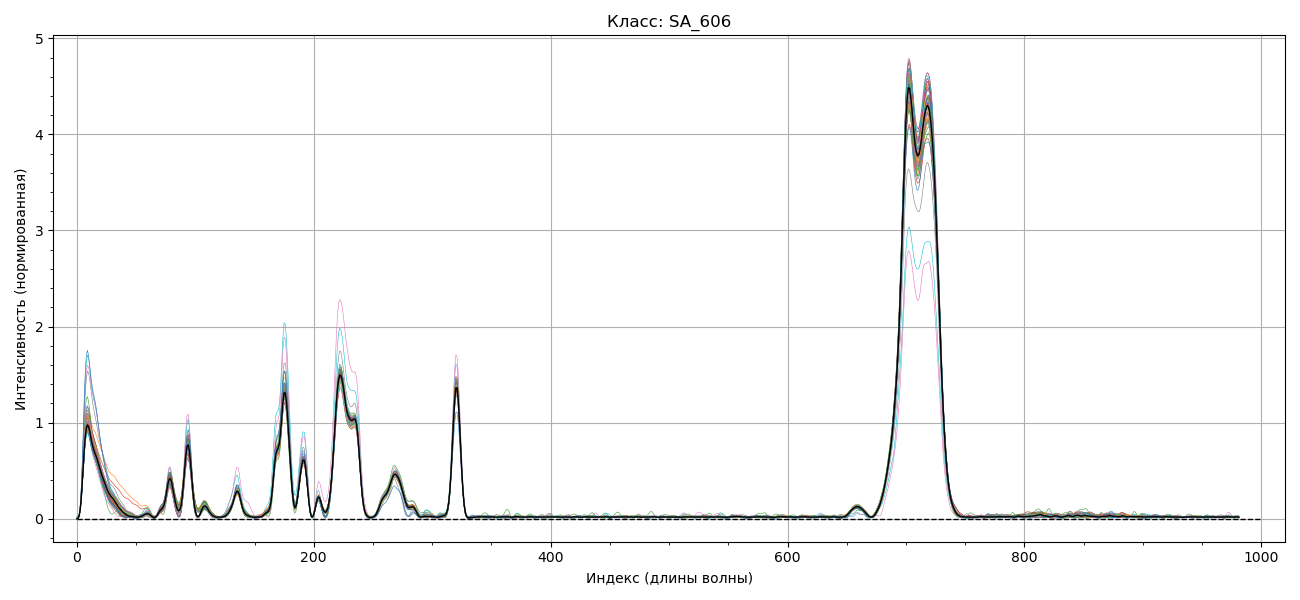

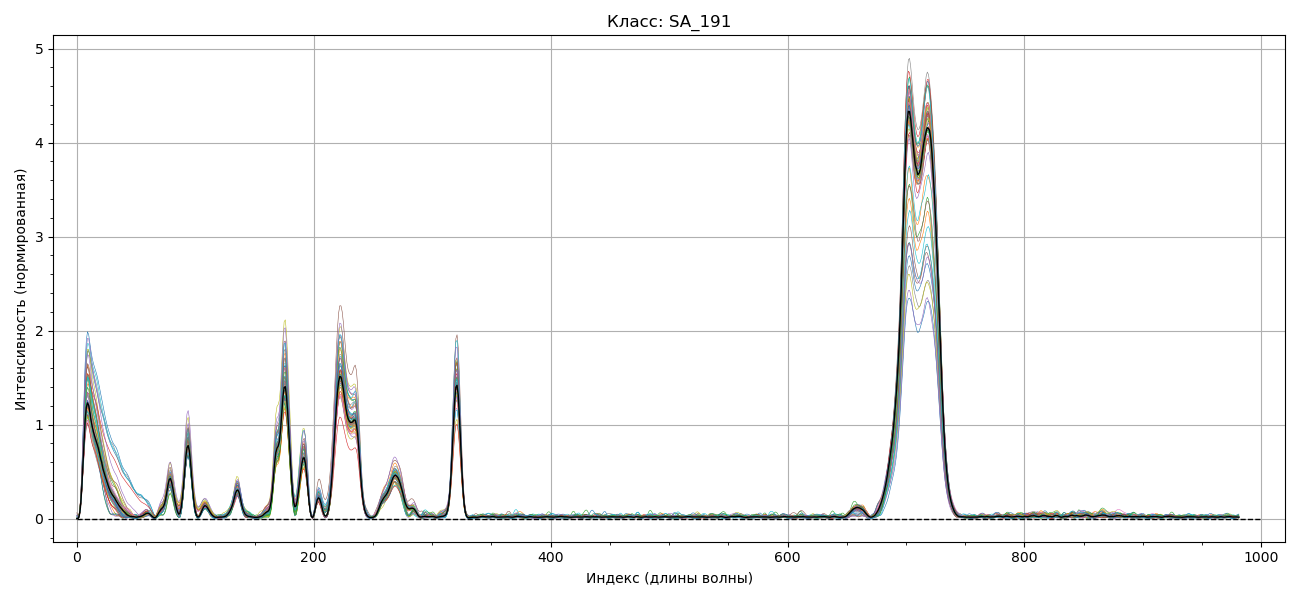

In [30]:
for i, key in enumerate(d):
    nn = len(d)
    Xs, Ys = d[key]
    if key == 'SA_191':
        color = 'b'
    if key == 'SA_606':
        color = 'r'

    plt.figure(figsize=(13,6))
    for xs, ys in zip(Xs, Ys):
        # plt.plot(ys, color=color, linewidth=0.5)
        plt.plot(ys, linewidth=0.4)    
        
    plt.plot(np.median(Ys, axis=0), color='k', linewidth=1.0)
    plt.hlines(0, 0, 1000, linewidth=1.0, colors='k', linestyle='--')
    plt.xlim(-20, 1020)
    plt.minorticks_on()
    plt.xlabel("Индекс (длины волны)")
    plt.ylabel("Интенсивность (нормированная)")
    plt.title(f"Класс: {key}")
    plt.grid(1)
    plt.tight_layout()
    plt.show()

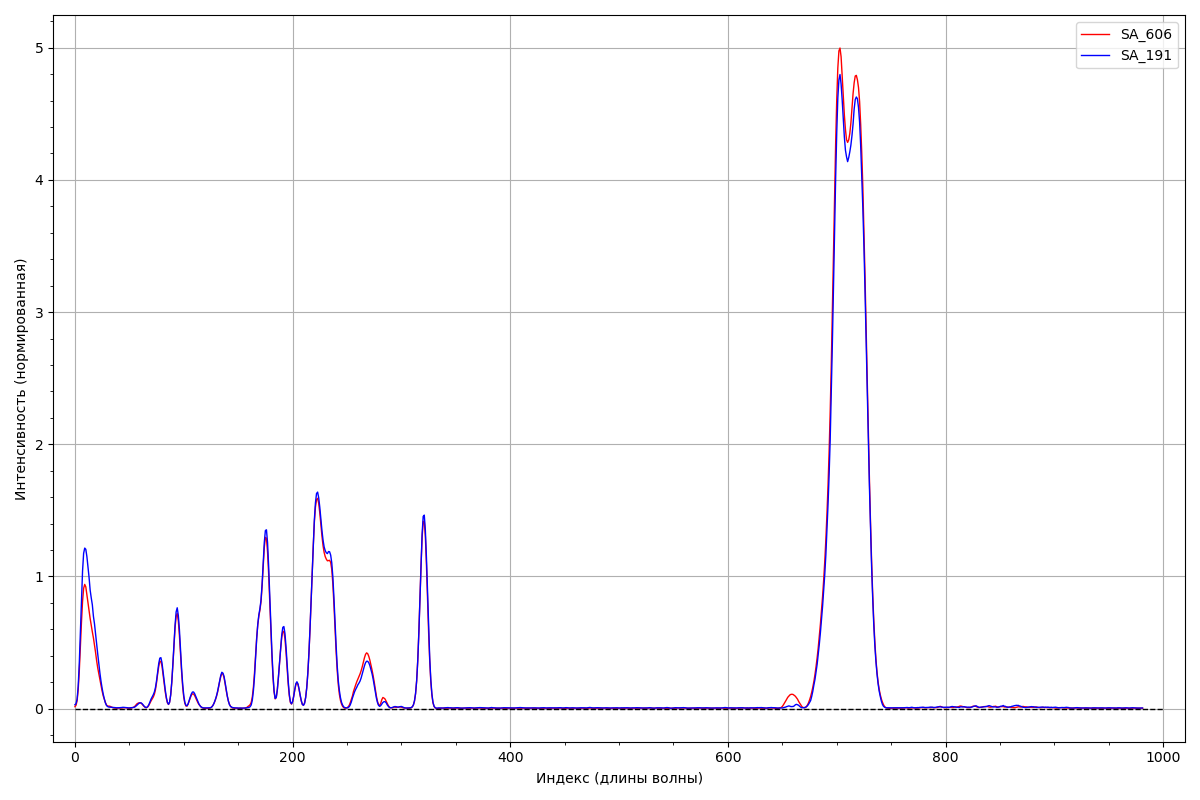

In [8]:
plt.figure(figsize=(12,8))
for i, key in enumerate(d):
    nn = len(d)
    Xs, Ys = d[key]
    if key == 'SA_191':
        color = 'b'
    if key == 'SA_606':
        color = 'r'

    ys = np.median(Ys, axis=0)
    # ys -= ys.min()
    ys /= np.trapz(ys, xs)
    ys *= 1000

    plt.plot(ys, color=color, linewidth=1.0, label=key)
    
plt.hlines(0, 0, 1000, linewidth=1.0, colors='k', linestyle='--')
plt.xlim(-20, 1020)
plt.minorticks_on()
plt.xlabel("Индекс (длины волны)")
plt.ylabel("Интенсивность (нормированная)")
plt.grid(1)
plt.tight_layout()
plt.legend()
plt.show()

In [35]:
for i, key in enumerate(d):
    Xs, Ys = d[key]
    if key == 'SA_606': # А
        XX2 = Ys
        YY2 = np.full(len(Ys), +1, 'd')
        print(f"Класс A: {len(Ys)} спектров")
    if key == 'SA_191': # B
        XX1 = Ys

YY1 = np.full(len(Ys), -1, 'd')
print(f"Класс B: {len(Ys)} спектров")

XX = np.concatenate((XX1, XX2), axis=0) 
YY = np.concatenate((YY1, YY2), axis=0) 
print(f"Всего {len(XX)} спектров")

print("Класс A: метка +1")
print("Класс B: метка -1")

XX = np.ascontiguousarray(XX)
YY = np.ascontiguousarray(YY)

N, n = XX.shape
print(r"Размерность вектора x:", n)

Класс A: 61 спектров
Класс B: 61 спектров
Всего 122 спектров
Класс A: метка +1
Класс B: метка -1
Размерность вектора x: 982


In [36]:
from sklearn.decomposition import PCA

(982, 2) (61,)
(982, 2) (61,)


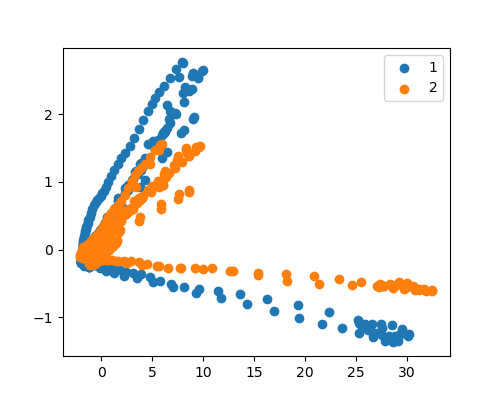

In [37]:
pca1 = PCA(2)
pca1.fit(XX1.T)
U1 = pca1.transform(XX1.T)
print(U1.shape, YY1.shape)

pca2 = PCA(2)
pca2.fit(XX2.T)
U2 = pca2.transform(XX2.T)
print(U2.shape, YY2.shape)

plt.figure(figsize=(5,4))
plt.scatter(U1[:,0], U1[:,1], label='1')
plt.scatter(U2[:,0], U2[:,1], label='2')
plt.legend()
plt.show()

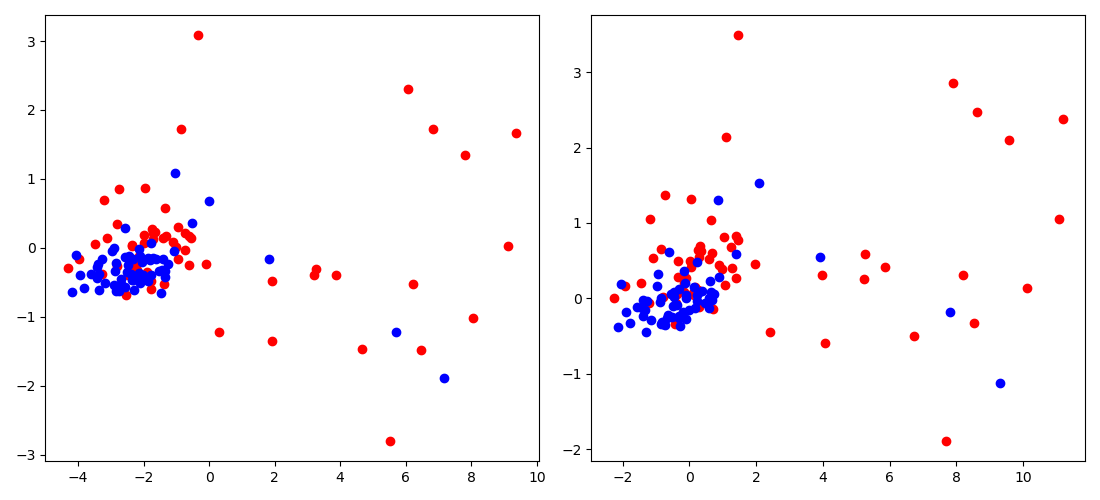

In [38]:
pca1 = PCA(2)
pca1.fit(XX1)
U1_1 = pca1.transform(XX1)
U1_2 = pca1.transform(XX2)
pca2 = PCA(2)
pca2.fit(XX2)
U2_1 = pca2.transform(XX1)
U2_2 = pca2.transform(XX2)

plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.scatter(U1_1[:,0], U1_1[:,1], c='r')
plt.scatter(U1_2[:,0], U1_2[:,1], c='b')
plt.subplot(1,2,2)
plt.scatter(U2_1[:,0], U2_1[:,1], c='r')
plt.scatter(U2_2[:,0], U2_2[:,1], c='b')
plt.tight_layout()
plt.show()

In [63]:
from mlgrad.pca import find_pc_all, find_robust_pc_all
from mlgrad.pca import robust_location, location
from mlgrad.funcs import Quantile_Sqrt
from mlgrad.af import averaging_function

wm = averaging_function("WM", Quantile_Sqrt(0.6, eps=0.001))

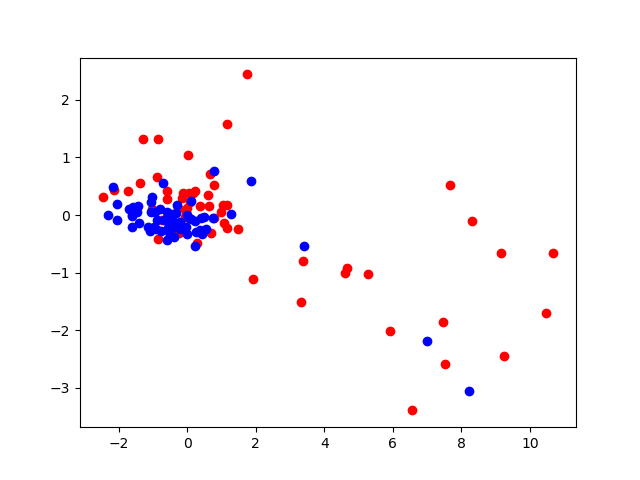

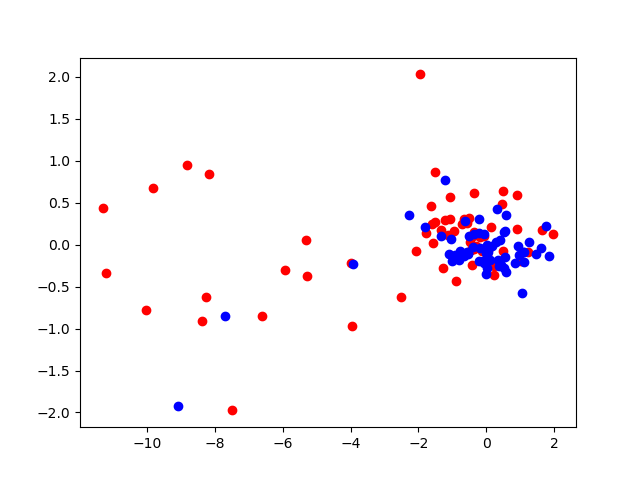

In [64]:
c1 = robust_location(XX1, wm)
XX1_c1 = XX1 - c1
As1, Ls1, Us1 = find_robust_pc_all(XX1_c1, wm, 2, verbose=False)
# print(As1, Ls1, Us1)
# print(Us1)
Us2 = As1 @ (XX2 - c1).T
# print(Us2)

plt.figure()
plt.scatter(Us1[0], Us1[1], c='r')
plt.scatter(Us2[0], Us2[1], c='b')
plt.show()

c2 = robust_location(XX2, wm)
XX2_c2 = XX2 - c2
As2, Ls2, Us2 = find_robust_pc_all(XX2_c2, wm, 2, verbose=False)
# print(As1, Ls1, Us1)
# print(Us1)
Us1 = As2 @ (XX1 - c2).T
# print(Us2)

plt.figure()
plt.scatter(Us1[0], Us1[1], c='r')
plt.scatter(Us2[0], Us2[1], c='b')
plt.show()


### Линейное разделение (функция Хинжа, без регуляризации)

$$
w^\star = \arg \min_{\mathbf{w}} 
\frac{1}{N}\sum_{k=1}^N 
H\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr)
$$
$$
H(u) = \max(-u,0)
$$

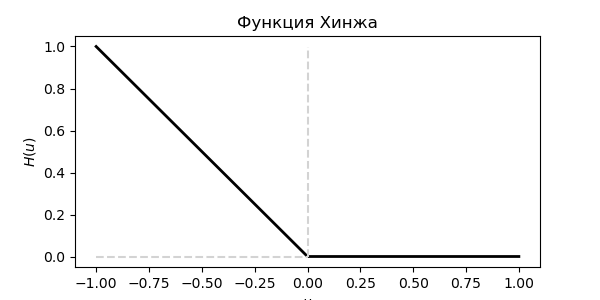

In [13]:
# График функции Хинжа
plt.figure(figsize=(6,3))
plt.plot([-1,0,1],[1,0,0], linewidth=2, color='k')
plt.title("Функция Хинжа")
plt.hlines(0,-1,0, linestyles='dashed', color='LightGrey')
plt.vlines(0,0,1, linestyles='dashed', color='LightGrey')
plt.xlabel(r"$u$")
plt.ylabel(r"$H(u)$")
plt.show()

In [14]:
mod1 = models.LinearModel(n) # линейная модель

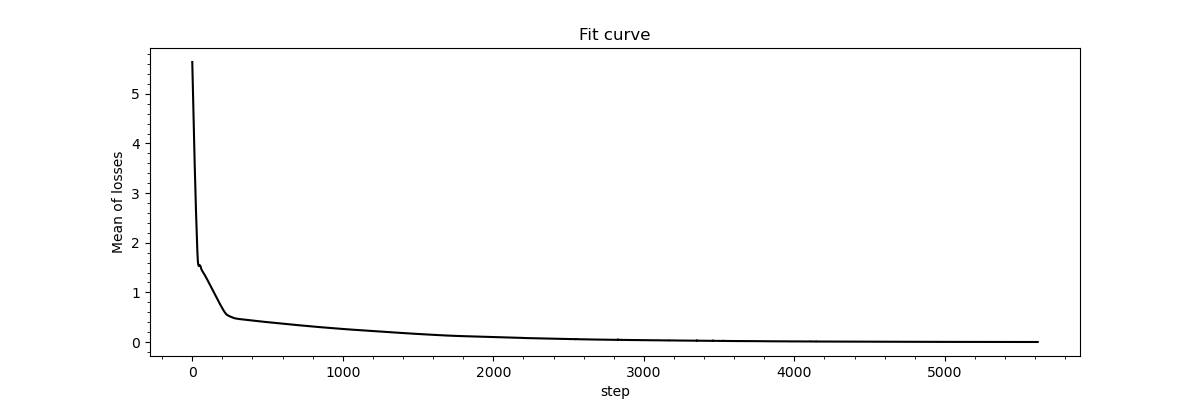

Относительное число правильных ответов: 1.0 1.0


In [15]:
alg1 = cls.classification_as_regr(XX, YY, mod1,
                                  lossfunc=hinge_loss, 
                                  normalizer=gd.Masked(mod1.n_param, 1.0e-5),
                                  h=0.001, n_iter=10000)

plt.figure(figsize=(12,4))
plots.plot_losses(alg1)
plt.show()

print("Относительное число правильных ответов:", 
        metrics.accuracy_score(YY1, np.sign(mod1.evaluate_all(XX1))),
        metrics.accuracy_score(YY2, np.sign(mod1.evaluate_all(XX2))))

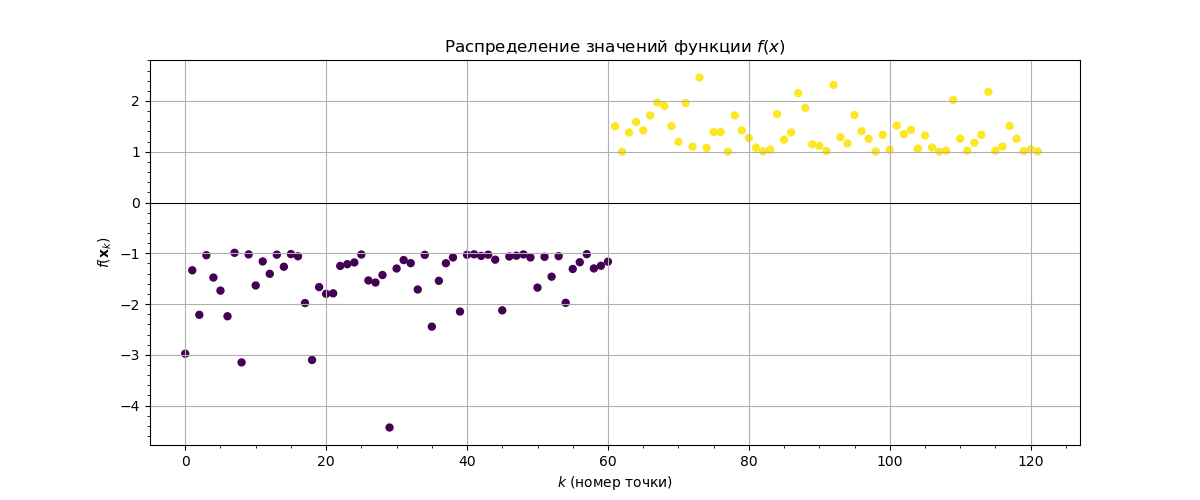

In [16]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod1, XX, YY)
plt.show()

982


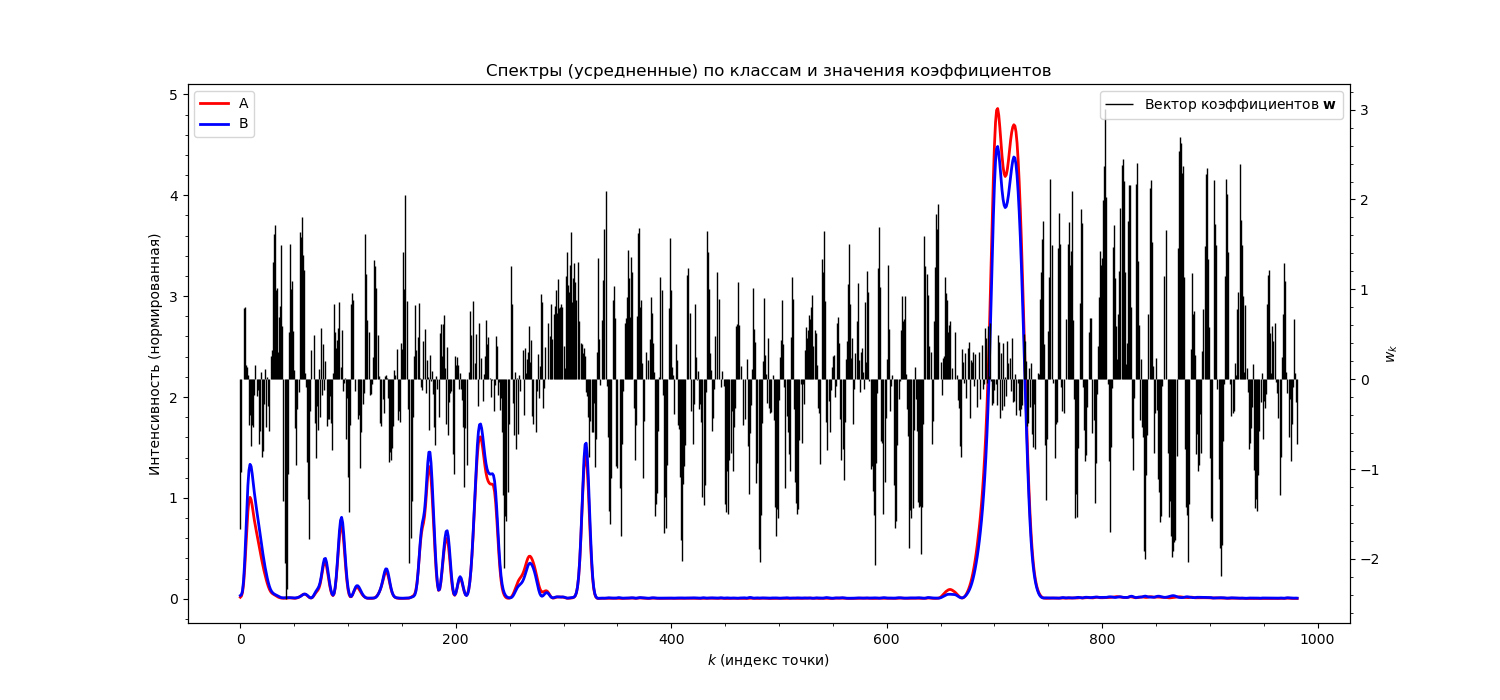

In [17]:
plt.figure(figsize=(15,7))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod1.param, ax=ax2)
plt.show()

### Линейное разделение (функция Хинжа, L2 регуляризация)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
H\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr) + \tau\|\mathbf{w}\|_2^2,
$$
$$
H(u) = \max(-u,0)
$$
$$
\|\mathbf{w}\|_2^2 = w_1^2+\cdots+w_n^2
$$

In [18]:
mod2 = models.LinearModel(n)

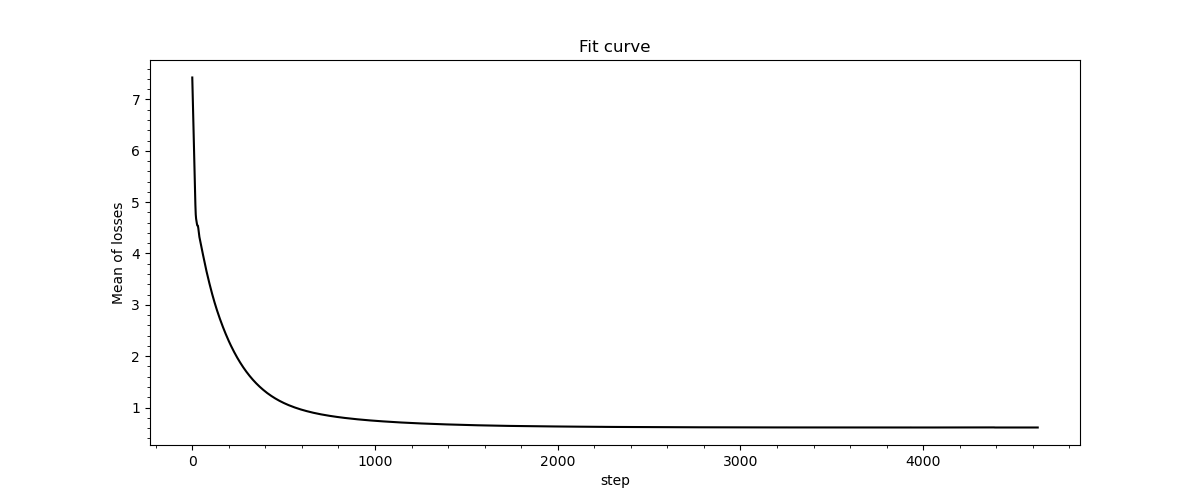

Относительное число правильных ответов: 0.7049180327868853 0.9180327868852459


In [19]:
alg2 = cls.classification_as_regr(XX, YY, mod2,
                                 lossfunc=hinge_loss, 
                                 regnorm=l2_reg, tau=0.1,
                                 normalizer=gd.Masked(mod2.n_param, 1.0e-2),
                                 h=0.001, n_iter=10000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg2)
plt.show()

print("Относительное число правильных ответов:", 
        metrics.accuracy_score(YY1, np.sign(mod2.evaluate_all(XX1))),
        metrics.accuracy_score(YY2, np.sign(mod2.evaluate_all(XX2))))

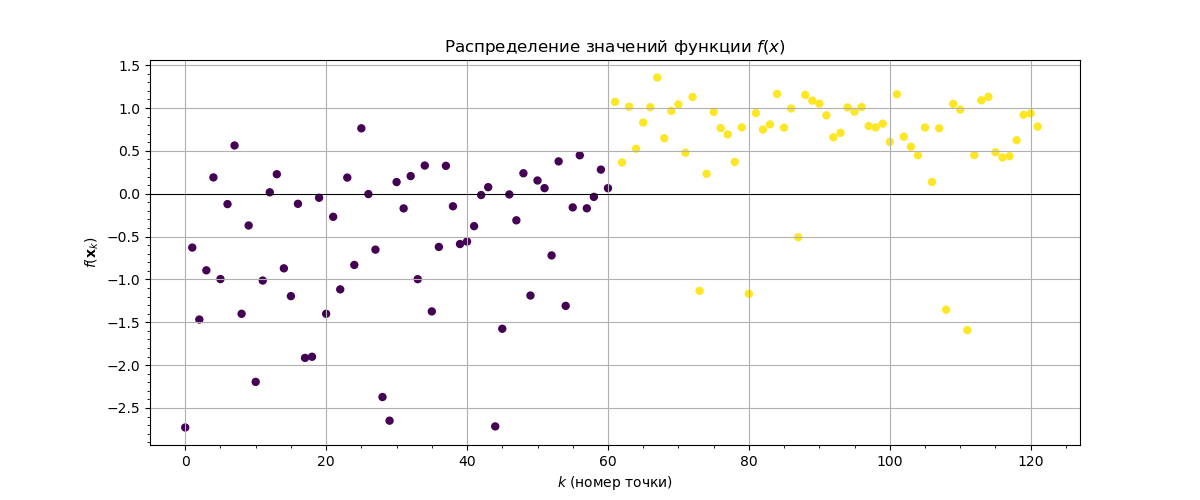

In [20]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod2, XX, YY)
plt.show()

982


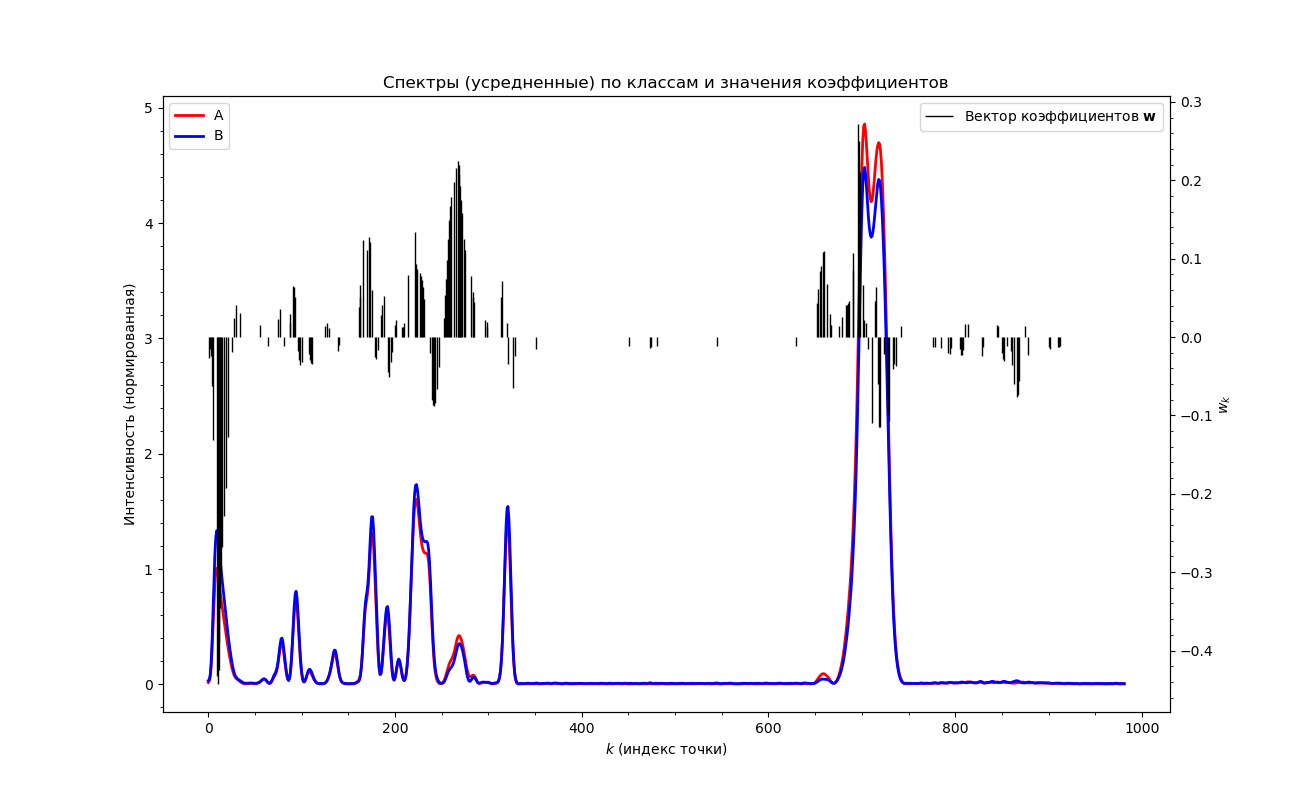

In [21]:
plt.figure(figsize=(13,8))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod2.param, ax=ax2)
plt.show()

### Линейное разделение (функция Хинжа, L1 регуляризацией)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
H\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr) + 
\tau\|\mathbf{w}\|_1,
$$
$$
H(u) = \max(-u,0)
$$
$$
\|\mathbf{w}\|_1 = |w_1|+\cdots+|w_n|
$$

In [22]:
mod3 = models.LinearModel(n)

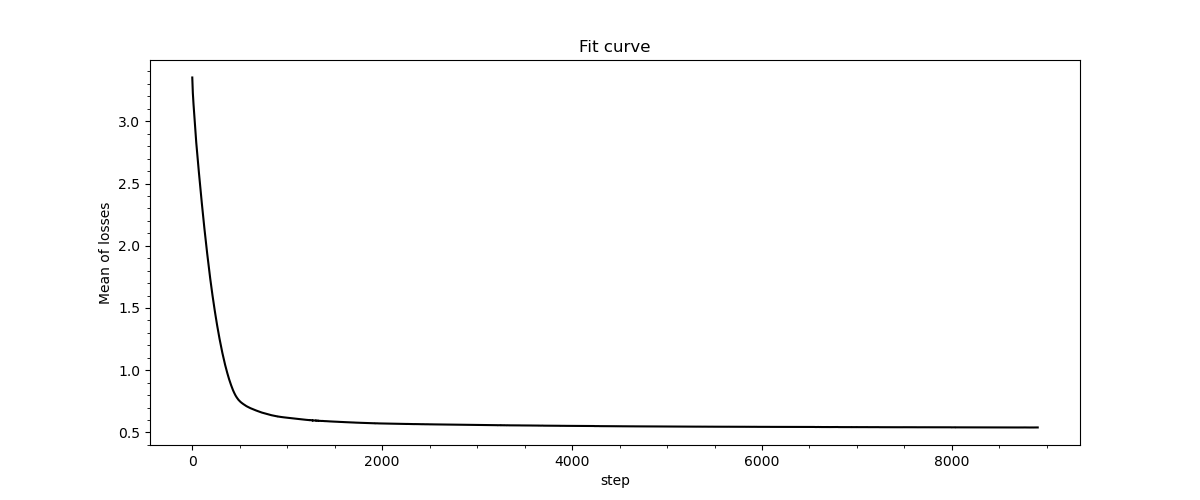

Относительное число правильных ответов: 0.8852459016393442 0.9180327868852459
32


In [23]:
alg3 = cls.classification_as_regr(XX, YY, mod3,
                                 lossfunc=hinge_loss, 
                                 regnorm=l1_reg, tau=0.01,
                                 normalizer=gd.Masked(mod3.n_param, 1.0e-6),
                                 h=0.001, n_iter=10000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg3)
plt.show()

print("Относительное число правильных ответов:", 
        metrics.accuracy_score(YY1, np.sign(mod3.evaluate_all(XX1))),
        metrics.accuracy_score(YY2, np.sign(mod3.evaluate_all(XX2))))

print((mod3.param.base != 0).sum())

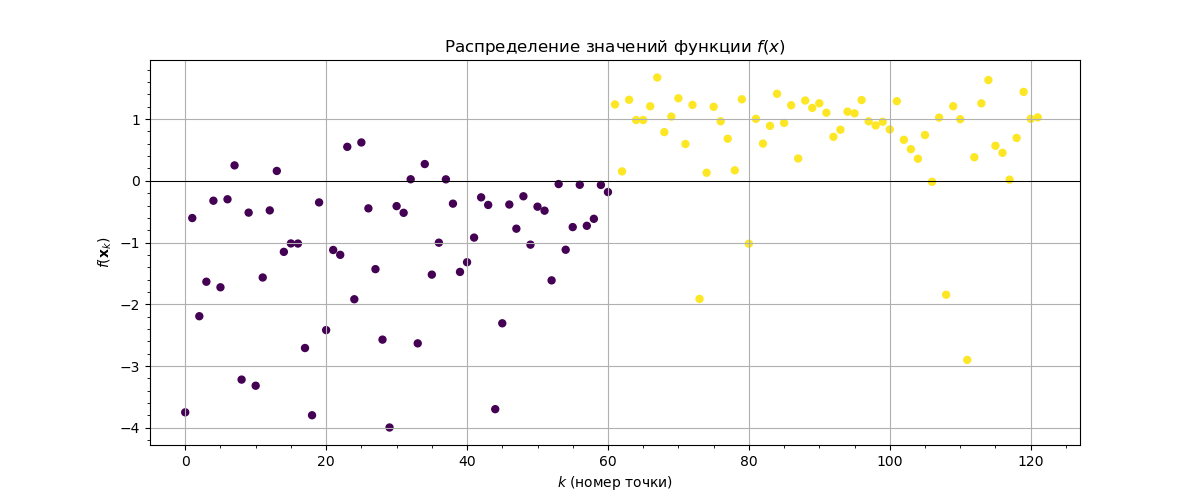

In [24]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod3, XX, YY)
plt.show()

982


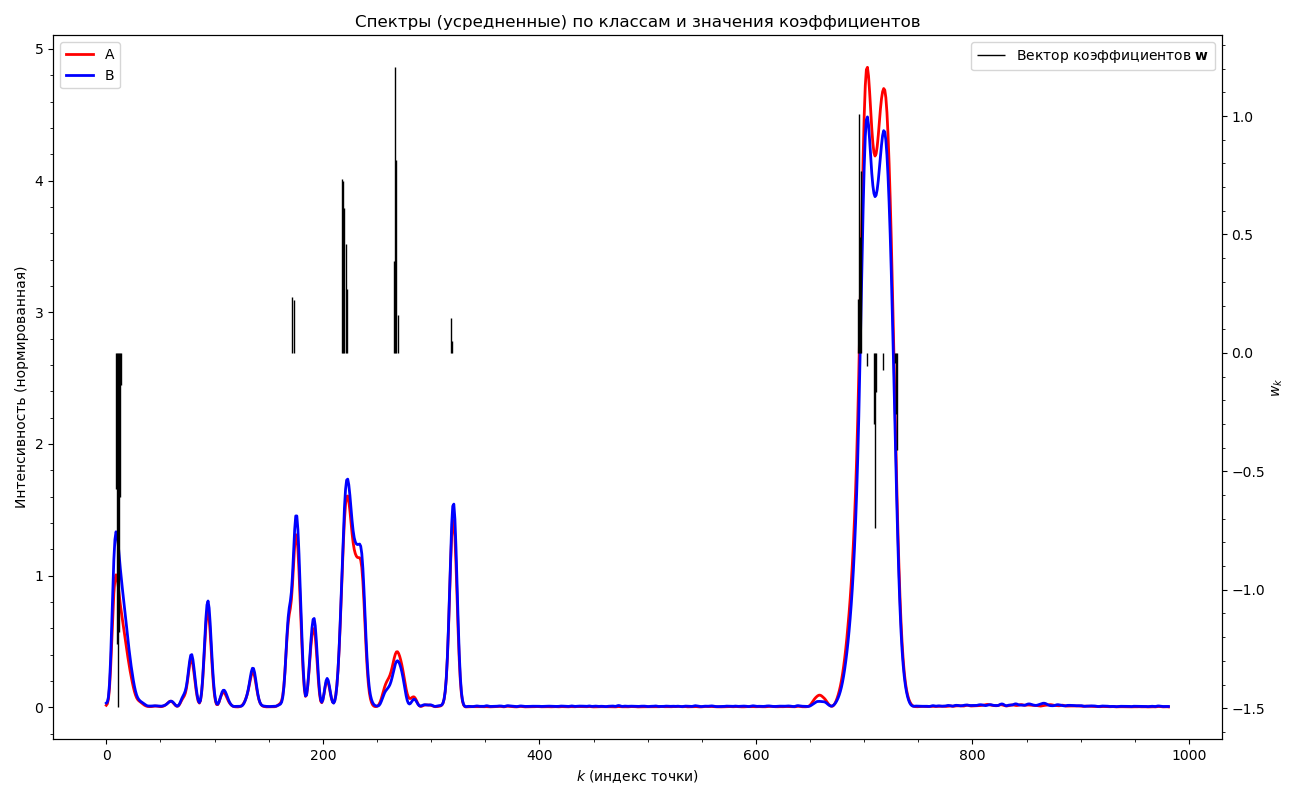

In [25]:
plt.figure(figsize=(13,8))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod3.param, ax=ax2)
plt.tight_layout()
plt.show()

In [ ]:
counts = np.zeros(XX.shape[1], 'i')
qwals = []
for i in range(50):
    _mod = models.LinearModel(n)
    for j in range(2):
        _alg = cls.classification_as_regr(XX, YY, _mod,
                                     lossfunc=hinge_loss, 
                                     regnorm=l1_reg, tau=0.01,
                                     normalizer=gd.Masked(_mod.n_param, 1.0e-6),
                                     h=0.001, n_iter=10000)
    _qwal = metrics.accuracy_score(YY, np.sign(_mod.evaluate_all(XX)))
    qwals.append(_qwal)
    
    I = np.argwhere(abs(_alg.risk.param.base[1:]) >= 0.001)[:,0]
    counts[I] += 1

# print(counts)

In [ ]:
plt.figure(figsize=(13,8))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(counts, ax=ax2)
plt.show()

plt.figure(figsize=(8,4))
plt.hist(qwals, bins=10)
plt.show()

In [ ]:
I1 = np.argwhere(counts > 5)[:,0]
XXI = np.ascontiguousarray(XX[:,I1])
print(XXI.shape, YY.shape)

In [ ]:
mod3_i = models.LinearModel(XXI.shape[1])

In [ ]:
alg3_i = cls.classification_as_regr(XXI, YY, mod3_i,
                                 lossfunc=hinge_loss, 
                                 regnorm=l1_reg, tau=0.01,
                                 normalizer=gd.Masked(mod3_i.n_param, 1.0e-6),
                                 h=0.001, n_iter=10000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg3_i)
plt.show()

print("Относительное число правильных ответов:", 
        metrics.accuracy_score(YY1, np.sign(mod3_i.evaluate_all(np.ascontiguousarray(XX1[:,I1])))),
        metrics.accuracy_score(YY2, np.sign(mod3_i.evaluate_all(np.ascontiguousarray(XX2[:,I1])))))

print((mod3_i.param.base != 0).sum())

In [ ]:
p = np.zeros(XX.shape[1]+1, 'd')
p[I1] = mod3_i.param[1:]
p[0] = mod3_i.param[0]

plt.figure(figsize=(13,8))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(p, ax=ax2)
plt.show()


## Линейное разделение (сигмоидальная функция)

$$
y = \sigma\bigl(w_0 + (\mathbf{w},\mathbf{x})\bigr)
$$
где
$$
\sigma(s) = \mathrm{th}(s) = \frac{e^{\alpha x} - e^{-\alpha x}}{e^{\alpha x} + e^{-\alpha x}}
$$

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\bigl(\sigma(w_0+(\mathbf{w},\mathbf{x}_k)) - y_k\bigr)^2 
$$


In [ ]:
# sigmoidal_func = funcs.Sigmoidal(6.0)
mod1_s = models.SigmaNeuronModel(sigmoidal_func, n)

In [ ]:
alg1_s = cls.classification_as_regr(XX, YY, mod1_s,
                                 lossfunc=sq_loss,
                                 normalizer=gd.Masked(mod1_s.n_param, 1.0e-5),
                                 h=0.001, n_iter=5000)
plt.figure(figsize=(12,3))
plt.plot(alg1_s.lvals)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(YY, np.sign(mod1_s.evaluate_all(XX))))

In [ ]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod1_s, XX, YY)
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod1.param, ax=ax2)
plt.show()

### Линейное разделение (максимизация отступа, с L2 регуляризацией)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\bigl(\sigma(w_0+(\mathbf{w},\mathbf{x}_k)) - y_k\bigr)^2 + 
\tau\|\mathbf{w}\|_2^2,
$$
$$
\|\mathbf{w}\|_2^2 = w_1^2+\cdots+w_n^2
$$

In [ ]:
mod2_s = models.SigmaNeuronModel(sigmoidal_func, n)

In [ ]:
alg2_s = cls.classification_as_regr(XX, YY, mod2_s,
                                 lossfunc=sq_loss, 
                                 regnorm=l2_reg, tau=0.05,
                                 normalizer=gd.Masked(mod2_s.n_param, 1.0e-5),
                                 h=0.001, n_iter=5000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg2_s)
plt.show()

print(metrics.accuracy_score(YY, np.sign(mod2_s.evaluate_all(XX))))
print((mod2_s.param.base != 0).sum())

In [ ]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod2_s, XX, YY)
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod2_s.param, ax=ax2)
plt.show()

### Линейное разделение (максимизация отступа, с L1 регуляризацией)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\sigma\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr) + \tau\|\mathbf{w}\|_1,
$$
$$
\|\mathbf{w}\|_1 = |w_1|+\cdots+|w_n|
$$

In [ ]:
mod3_s = models.SigmaNeuronModel(sigmoidal_func, n)

In [ ]:
alg3_s = cls.classification_as_regr(XX, YY, mod3_s,
                                 lossfunc=sq_loss, 
                                 regnorm=l1_reg, tau=0.05,
                                 normalizer=gd.Masked(mod3_s.n_param, 1.0e-6),
                                 h=0.001, n_iter=10000, n_restart=2)
plt.figure(figsize=(12,5))
plots.plot_losses(alg3_s)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(YY1, np.sign(mod3_s.evaluate_all(XX1))),
      metrics.accuracy_score(YY2, np.sign(mod3_s.evaluate_all(XX2))),
      metrics.accuracy_score(YY, np.sign(mod3_s.evaluate_all(XX))),)

print((mod3_s.param.base != 0).sum())

mod3_s.param.base[:] = 5*mod3_s.param.base

In [ ]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod3_s, XX, YY)
plt.show()

In [ ]:
plt.figure(figsize=(13,8))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod3_s.param, ax=ax2)
plt.show()

In [ ]:
counts = np.zeros(XX.shape[1], 'i')
qwals = []
for i in range(50):
    _mod = models.SigmaNeuronModel(sigmoidal_func2, n)
    _alg = cls.classification_as_regr(XX, YY, _mod,
                                     lossfunc=sq_loss, 
                                     regnorm=l1_reg, tau=0.02,
                                     normalizer=gd.Masked(_mod.n_param, 1.0e-6),
                                     h=0.001, n_iter=10000, n_restart=2)
    _qwal = metrics.accuracy_score(YY, np.sign(_mod.evaluate_all(XX)))
    qwals.append(_qwal)
    
    I = np.argwhere(abs(_alg.risk.param.base[1:]) >= 0.001)[:,0]
    counts[I] += 1

# print(counts)

In [ ]:
plt.figure(figsize=(13,8))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(counts, ax=ax2)
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.hist(qwals, rwidth=0.9)
plt.show()

In [ ]:
I1 = np.argwhere(counts > 5)[:,0]
XXI = np.ascontiguousarray(XX[:,I1])
print(XXI.shape, YY.shape)

In [ ]:
mod3_s1 = models.SigmaNeuronModel(sigmoidal_func2, XXI.shape[1])
alg3_s1 = cls.classification_as_regr(XXI, YY, mod3_s1,
                                 lossfunc=sq_loss, 
                                 regnorm=l1_reg, tau=0.02,
                                 normalizer=gd.Masked(mod3_s1.n_param, 1.0e-6),
                                 h=0.001, n_iter=10000, n_restart=1)
plt.figure(figsize=(12,5))
plots.plot_losses(alg3_s1)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(YY1, np.sign(mod3_s1.evaluate_all(np.ascontiguousarray(XX1[:,I1])))),
      metrics.accuracy_score(YY2, np.sign(mod3_s1.evaluate_all(np.ascontiguousarray(XX2[:,I1])))),
      metrics.accuracy_score(YY, np.sign(mod3_s1.evaluate_all(XXI))),)

print((mod3_s1.param.base != 0).sum())

In [ ]:
p = np.zeros(XX.shape[1]+1, 'd')
p[I1] = mod3_s1.param[1:]
p[0] = mod3_s1.param[0]

plt.figure(figsize=(13,8))
ax1 = plt.gca()
plot_spectra(d, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(p, ax=ax2)
plt.show()


In [ ]:
n_hidden = 10
linear4 = models.LinearLayer(XX.shape[1], n_hidden)
scaler4 = models.ScaleLayer(sigmoidal_func, n_hidden)
body4 = models.FFNetworkModel()
body4.add(linear4)
body4.add(scaler4)
head4 = models.LinearModel(n_hidden)
mod4_s = models.FFNetworkFuncModel(head4, body4)
mod4_s.allocate()
mod4_s.init_param()

In [ ]:
alg4_s = cls.classification_as_regr(XX, YY, mod4_s,
                                 lossfunc=sq_loss, 
                                 regnorm=l1_reg, tau=0.02,
                                 normalizer=gd.Masked(mod4_s.n_param, 1.0e-4),
                                 h=0.001, n_iter=10000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg4_s)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(YY1, np.sign(mod4_s.evaluate_all(XX1))),
      metrics.accuracy_score(YY2, np.sign(mod4_s.evaluate_all(XX2))))

In [ ]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod4_s, XX, YY)
plt.show()

In [ ]:
plt.figure(figsize=(14,4))
plot_params(mod4_s.param)
plt.vlines([n_hidden+XX.shape[1]*i for i in range(n_hidden)], 0,4)
plt.show()

In [ ]:
n_hidden = 7
linear5 = models.LinearLayer(XX.shape[1], n_hidden)
scaler5 = models.ScaleLayer(sigmoidal_func, n_hidden)
body5 = models.FFNetworkModel()
body5.add(linear5)
body5.add(scaler5)
head5 = models.LinearModel(n_hidden)
mod5_s = models.FFNetworkFuncModel(head5, body5)
mod5_s.allocate()
mod5_s.init_param()

In [ ]:
alg5_s = cls.classification_as_regr(XX, YY, mod5_s,
                                 lossfunc=hinge_loss, 
                                 regnorm=l1_reg, tau=0.02,
                                 normalizer=gd.Masked(mod5_s.n_param, 1.0e-6),
                                 h=0.001, n_iter=10000, n_restart=3)
plt.figure(figsize=(12,5))
plots.plot_losses(alg5_s)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(YY1, np.sign(mod5_s.evaluate_all(XX1))),
      metrics.accuracy_score(YY2, np.sign(mod5_s.evaluate_all(XX2))))

In [ ]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod5_s, XX, YY)
plt.show()

In [ ]:
plt.figure(figsize=(20,4))
plot_params(mod5_s.param)
plt.vlines([n_hidden+(XX.shape[1]+1)*i for i in range(n_hidden)], 0,3)
plt.show()